In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


### Install and load extension

In [2]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Source files will be saved in "/tmp/tmpab434qfs".


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

###Unified Memory Management

In [5]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>
#include <cuda_runtime_api.h>

#define tile_width 32

__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(){

    int block_size = 256, matrix_size = 16384;

    //Create and allocate memory for the matrices
    double *a, *b, *c;
    cudaMallocManaged((void **)&a, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&b, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&c, sizeof(double) * matrix_size * matrix_size);

    // initialize matrix A
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        a[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix B
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        b[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix C
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        c[i * matrix_size + j] = 0;
      }
    }

    float gpu_elapsed_time_ms;

    // create cuda events for timing purposes
    cudaEvent_t gpu_start, gpu_stop;
    cudaEventCreate(&gpu_start);
    cudaEventCreate(&gpu_stop);

    //Define block size
    unsigned int grid_rows = (matrix_size + block_size - 1) / block_size;
    unsigned int grid_cols = (matrix_size + block_size - 1) / block_size;
    dim3 dimGrid(grid_cols, grid_rows);
    dim3 dimBlock(block_size, block_size);

    //Launch GPU Kernel
    cudaEventRecord(gpu_start, 0);
    gpu_matrix_mult<<<dimGrid, dimBlock>>>(a, b, c, matrix_size);
    cudaEventRecord(gpu_stop, 0);
    cudaEventSynchronize(gpu_stop);

    //Calculate elapsed time
    cudaEventElapsedTime(&gpu_elapsed_time_ms, gpu_start, gpu_stop);
    printf("Time elapsed on Naive matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, gpu_elapsed_time_ms);

    // free memory
    cudaFree(a);
    cudaFree(b);
    cudaFree(c);

    return 0;
}


Time elapsed on Naive matrix multiplication of 16384x16384 on GPU: 141.510559 ms.




####Multiple Sizes

In [6]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <immintrin.h>
#include <cuda.h>
#include <algorithm>
#include <random>
#include <fstream>
#include <iostream>


__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(int argc, char const *argv[])
{

  //Open File
  std::ofstream file("ResultsUnified.csv");

  file << "MatrixSize,BlockSize,Time" << "\n";

  int block_size;
  int MATRIX_SIZE;

  //Try different matrix Sizes
  for(MATRIX_SIZE = 32; MATRIX_SIZE <= 2048; MATRIX_SIZE *= 2){

    //Try different block sizes
    for (block_size = 8; block_size <= 128; block_size *= 2)
    {
      //Create and allocate memory for the matrices
      double *a, *b, *c;
      // Use Unified Memory for matrix allocation
      cudaMallocManaged((void **)&a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMallocManaged((void **)&b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMallocManaged((void **)&c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);

      // initialize matrix A
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          a[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
        }
      }

      // initialize matrix B
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          b[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
        }
      }

      // initialize matrix C
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          c[i * MATRIX_SIZE + j] = 0;
        }
      }

      float naive_gpu_time;

      //Events to count the execution time
      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      unsigned int grid_rows = (MATRIX_SIZE + block_size - 1) / block_size;
      unsigned int grid_cols = (MATRIX_SIZE + block_size - 1) / block_size;
      dim3 dimGrid(grid_cols, grid_rows);
      dim3 dimBlock(block_size, block_size);

      cudaEventRecord(start, 0);
      gpu_matrix_mult<<<dimGrid, dimBlock>>>(a, b, c, MATRIX_SIZE);
      //Synchronize threads
      cudaDeviceSynchronize();

      //Terminate time counting
      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);

      //Compute elapsed time on GPU computing
      cudaEventElapsedTime(&naive_gpu_time, start, stop);
      printf("Time elapsed on naive GPU matrix multiplication of %dx%d (%d): %f ms.\n\n", MATRIX_SIZE, MATRIX_SIZE, block_size, naive_gpu_time);

      file<< MATRIX_SIZE << ", " << block_size << ", " << naive_gpu_time << "\n";

      // free memory
      cudaFree(a);
      cudaFree(b);
      cudaFree(c);
    }
    printf("______________________________________\n\n");
  }

  file.close();

  return 0;
}

Time elapsed on naive GPU matrix multiplication of 32x32 (8): 0.665600 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 (16): 0.169888 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 (32): 0.169568 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 (64): 0.008864 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 (128): 0.008544 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 64x64 (8): 0.307232 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 (16): 0.276992 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 (32): 0.257440 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 (64): 0.008448 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 (128): 0.008640 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 128x128 (8): 0.479520 ms.

Time elapsed on naive GPU matrix multiplication of 128x128 (16): 0.38707

####Large Matrices

In [7]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <immintrin.h>
#include <cuda.h>
#include <algorithm>
#include <random>
#include <fstream>
#include <iostream>

__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(int argc, char const *argv[])
{

  //Open File
  std::ofstream file("ResultsUnifiedLarge.csv");

  file << "MatrixSize,BlockSize,Time" << "\n";

  int block_size;
  int MATRIX_SIZE;

  //Try different matrix sizes
  for(MATRIX_SIZE = 2048; MATRIX_SIZE <= 16384; MATRIX_SIZE *= 2){

    //Try different block sizes
    for (block_size = 64; block_size <= 512; block_size *= 2)
    {
      //Create and allocate memory for the matrices
      double *a, *b, *c;
      // Use Unified Memory for matrix allocation
      cudaMallocManaged((void **)&a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMallocManaged((void **)&b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMallocManaged((void **)&c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);

      // initialize matrix A
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          a[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
        }
      }

      // initialize matrix B
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          b[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
        }
      }

      // initialize matrix C
      for (int i = 0; i < MATRIX_SIZE; ++i){
        for (int j = 0; j < MATRIX_SIZE; ++j){
          c[i * MATRIX_SIZE + j] = 0;
        }
      }

      float naive_gpu_time;

      //Events to count the execution time
      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      unsigned int grid_rows = (MATRIX_SIZE + block_size - 1) / block_size;
      unsigned int grid_cols = (MATRIX_SIZE + block_size - 1) / block_size;
      dim3 dimGrid(grid_cols, grid_rows);
      dim3 dimBlock(block_size, block_size);

      cudaEventRecord(start, 0);
      gpu_matrix_mult<<<dimGrid, dimBlock>>>(a, b, c, MATRIX_SIZE);
      //Synchronize threads
      cudaDeviceSynchronize();

      //Terminate time counting
      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);

      //Compute elapsed time on GPU computing
      cudaEventElapsedTime(&naive_gpu_time, start, stop);
      printf("Time elapsed on naive GPU matrix multiplication of %dx%d (%d): %f ms.\n\n", MATRIX_SIZE, MATRIX_SIZE, block_size, naive_gpu_time);

      file<< MATRIX_SIZE << ", " << block_size << ", " << naive_gpu_time << "\n";

      // free memory
      cudaFree(a);
      cudaFree(b);
      cudaFree(c);
    }
    printf("______________________________________\n\n");
  }

  file.close();

  return 0;
}

Time elapsed on naive GPU matrix multiplication of 2048x2048 (64): 0.256000 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 (128): 0.015328 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 (256): 0.015008 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 (512): 0.014976 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 4096x4096 (64): 0.014624 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 (128): 0.015136 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 (256): 0.016096 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 (512): 0.014592 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 8192x8192 (64): 0.019520 ms.

Time elapsed on naive GPU matrix multiplication of 8192x8192 (128): 0.014816 ms.

Time elapsed on naive GPU matrix multiplication of 8192x8192 (256): 0.015584 ms.

Time elapsed on naive

####Plot Results

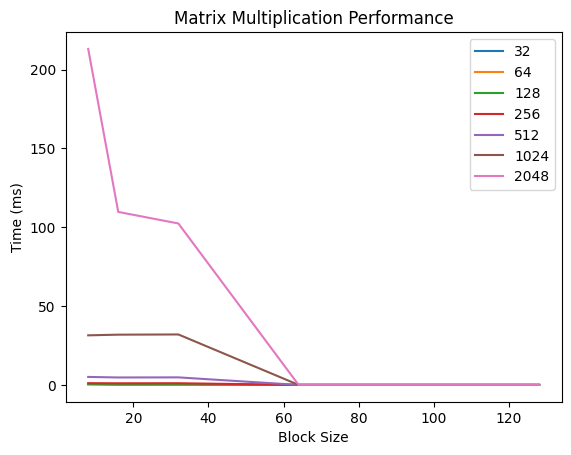

In [8]:
# Read the CSV file into a DataFrame
df = pd.read_csv('ResultsUnified.csv')

# Extract data
matrix_sizes = df['MatrixSize'].unique()

# Create a line plot for each matrix size
for size in matrix_sizes:
    subset = df[df['MatrixSize'] == size]
    plt.plot(subset['BlockSize'], subset['Time'], label=f'{size}')

# Set labels and title
plt.xlabel('Block Size')
plt.ylabel('Time (ms)')
plt.title('Matrix Multiplication Performance')

# Show legend
plt.legend()

# Show the plot
plt.show()


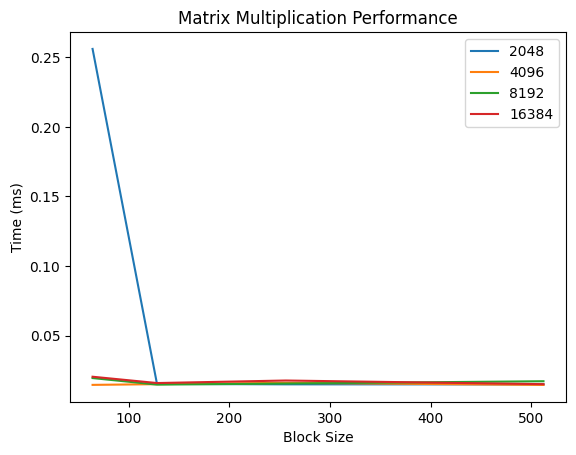

In [9]:
# Read the CSV file into a DataFrame
df = pd.read_csv('ResultsUnifiedLarge.csv')

# Extract data
matrix_sizes = df['MatrixSize'].unique()

# Create a line plot for each matrix size
for size in matrix_sizes:
    subset = df[df['MatrixSize'] == size]
    plt.plot(subset['BlockSize'], subset['Time'], label=f'{size}')

# Set labels and title
plt.xlabel('Block Size')
plt.ylabel('Time (ms)')
plt.title('Matrix Multiplication Performance')

# Show legend
plt.legend()

# Show the plot
plt.show()


### Manual memory management

In [10]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <immintrin.h>
#include <cuda.h>
#include <algorithm>
#include <random>
#include <fstream>
#include <iostream>
#include <string>


__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(int argc, char const *argv[])
{
  //Open File
  std::ofstream file("ResultsManual.csv");

  file << "MatrixSize,BlockSize,Time" << "\n";

  int block_size = 256, MATRIX_SIZE = 16384;

  //Create and allocate memory for the matrices in the host (CPU)
  double *a = new double[MATRIX_SIZE * MATRIX_SIZE];
  double *b = new double[MATRIX_SIZE * MATRIX_SIZE];
  double *c = new double[MATRIX_SIZE * MATRIX_SIZE];

  // initialize matrix A
  for (int i = 0; i < MATRIX_SIZE; ++i){
      for (int j = 0; j < MATRIX_SIZE; ++j)
      {
          a[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
      }
  }

  // initialize matrix B
  for (int i = 0; i < MATRIX_SIZE; ++i){
      for (int j = 0; j < MATRIX_SIZE; ++j){
          b[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
      }
  }

  // initialize matrix C
  for (int i = 0; i < MATRIX_SIZE; ++i){
      for (int j = 0; j < MATRIX_SIZE; ++j){
          c[i * MATRIX_SIZE + j] = 0;
      }
  }

  //Create and allocate memory for the matrices in the device (GPU)
  double *d_a, *d_b, *d_c;
  cudaMalloc((void **)&d_a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
  cudaMalloc((void **)&d_b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
  cudaMalloc((void **)&d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);

  //Copy the matrices from the host (CPU) to the device (GPU)
  cudaMemcpy(d_a, a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
  cudaMemcpy(d_b, b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
  cudaMemcpy(d_c, c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);

  float naive_gpu_time;

  //Events to count the execution time
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  unsigned int grid_rows = (MATRIX_SIZE + block_size - 1) / block_size;
  unsigned int grid_cols = (MATRIX_SIZE + block_size - 1) / block_size;
  dim3 dimGrid(grid_cols, grid_rows);
  dim3 dimBlock(block_size, block_size);

  cudaEventRecord(start, 0);
  gpu_matrix_mult<<<dimGrid, dimBlock>>>(d_a,d_b,d_c, MATRIX_SIZE);
  //Synchronize threads
  cudaDeviceSynchronize();

  //Terminate time counting
  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);

  //Copy the result matrix from the device (GPU) to the host (CPU)
  cudaMemcpy(c, d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyDeviceToHost);

  //Compute elapsed time on GPU computing
  cudaEventElapsedTime(&naive_gpu_time, start, stop);
  printf("Time elapsed on naive GPU matrix multiplication of %dx%d (%d): %f ms.\n\n", MATRIX_SIZE, MATRIX_SIZE, block_size, naive_gpu_time);

  file << MATRIX_SIZE << ", " << block_size << ", " << naive_gpu_time << "\n";

  // free memory
  cudaFree(a);
  cudaFree(b);
  cudaFree(c);

  return 0;
}

Time elapsed on naive GPU matrix multiplication of 16384x16384 (256): 0.284288 ms.




####Multiple Sizes

In [11]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <immintrin.h>
#include <cuda.h>
#include <algorithm>
#include <random>
#include <fstream>
#include <iostream>
#include <string>


__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(int argc, char const *argv[])
{
  //Open File
  std::ofstream file("ResultsManual.csv");

  file << "MatrixSize,BlockSize,Time" << "\n";

  int block_size;
  int MATRIX_SIZE;

  for(MATRIX_SIZE = 32; MATRIX_SIZE <= 2048; MATRIX_SIZE *= 2){

    //try different block sizes
    for (block_size = 8; block_size <= 64; block_size *= 2)
    {
      //Create and allocate memory for the matrices in the host (CPU)
      double *a = new double[MATRIX_SIZE * MATRIX_SIZE];
      double *b = new double[MATRIX_SIZE * MATRIX_SIZE];
      double *c = new double[MATRIX_SIZE * MATRIX_SIZE];

      // initialize matrix A
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j)
          {
              a[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
          }
      }

      // initialize matrix B
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j){
              b[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
          }
      }

      // initialize matrix C
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j){
              c[i * MATRIX_SIZE + j] = 0;
          }
      }

      //Create and allocate memory for the matrices in the device (GPU)
      double *d_a, *d_b, *d_c;
      cudaMalloc((void **)&d_a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMalloc((void **)&d_b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMalloc((void **)&d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);

      //Copy the matrices from the host (CPU) to the device (GPU)
      cudaMemcpy(d_a, a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
      cudaMemcpy(d_b, b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
      cudaMemcpy(d_c, c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);

      float naive_gpu_time;

      //Events to count the execution time
      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      unsigned int grid_rows = (MATRIX_SIZE + block_size - 1) / block_size;
      unsigned int grid_cols = (MATRIX_SIZE + block_size - 1) / block_size;
      dim3 dimGrid(grid_cols, grid_rows);
      dim3 dimBlock(block_size, block_size);

      cudaEventRecord(start, 0);
      gpu_matrix_mult<<<dimGrid, dimBlock>>>(d_a,d_b,d_c, MATRIX_SIZE);
      //Synchronize threads
      cudaDeviceSynchronize();

      //Terminate time counting
      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);

      //Copy the result matrix from the device (GPU) to the host (CPU)
      cudaMemcpy(c, d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyDeviceToHost);

      //Compute elapsed time on GPU computing
      cudaEventElapsedTime(&naive_gpu_time, start, stop);
      printf("Time elapsed on naive GPU matrix multiplication of %dx%d . %dx%d (%d): %f ms.\n\n", MATRIX_SIZE, MATRIX_SIZE, MATRIX_SIZE, MATRIX_SIZE, block_size, naive_gpu_time);

      file << MATRIX_SIZE << ", " << block_size << ", " << naive_gpu_time << "\n";

      // free memory
      cudaFree(a);
      cudaFree(b);
      cudaFree(c);
    }
    printf("______________________________________\n\n");
  }

  return 0;
}

Time elapsed on naive GPU matrix multiplication of 32x32 . 32x32 (8): 0.195168 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 . 32x32 (16): 0.020896 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 . 32x32 (32): 0.043360 ms.

Time elapsed on naive GPU matrix multiplication of 32x32 . 32x32 (64): 0.007104 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 64x64 . 64x64 (8): 0.020064 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 . 64x64 (16): 0.025600 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 . 64x64 (32): 0.071264 ms.

Time elapsed on naive GPU matrix multiplication of 64x64 . 64x64 (64): 0.006528 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 128x128 . 128x128 (8): 0.069824 ms.

Time elapsed on naive GPU matrix multiplication of 128x128 . 128x128 (16): 0.075232 ms.

Time elapsed on naive GPU matrix multiplication of 128x128 . 128x

####Large Matrices

In [12]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <immintrin.h>
#include <cuda.h>
#include <algorithm>
#include <random>
#include <fstream>
#include <iostream>
#include <string>

__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(int argc, char const *argv[])
{
  //Open File
  std::ofstream file("ResultsManualLarge.csv");

  file << "MatrixSize,BlockSize,Time" << "\n";

  int block_size;
  int MATRIX_SIZE;

  //Try different Matrix Sizes
  for(MATRIX_SIZE = 2048; MATRIX_SIZE <= 8192; MATRIX_SIZE *= 2){

    //try different block sizes
    for (block_size = 32; block_size <= 512; block_size *= 2)
    {
      //Create and allocate memory for the matrices in the host (CPU)
      double *a = new double[MATRIX_SIZE * MATRIX_SIZE];
      double *b = new double[MATRIX_SIZE * MATRIX_SIZE];
      double *c = new double[MATRIX_SIZE * MATRIX_SIZE];

      // initialize matrix A
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j){
              a[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
          }
      }

      // initialize matrix B
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j){
              b[i * MATRIX_SIZE + j] = (double(rand() % 50))/10.0;
          }
      }

      // initialize matrix B
      for (int i = 0; i < MATRIX_SIZE; ++i){
          for (int j = 0; j < MATRIX_SIZE; ++j){
              c[i * MATRIX_SIZE + j] = 0;
          }
      }

      //Create and allocate memory for the matrices in the device (GPU)
      double *d_a, *d_b, *d_c;
      cudaMalloc((void **)&d_a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMalloc((void **)&d_b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);
      cudaMalloc((void **)&d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE);

      //Copy the matrices from the host (CPU) to the device (GPU)
      cudaMemcpy(d_a, a, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
      cudaMemcpy(d_b, b, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);
      cudaMemcpy(d_c, c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyHostToDevice);

      float naive_gpu_time;

      //Events to count the execution time
      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      unsigned int grid_rows = (MATRIX_SIZE + block_size - 1) / block_size;
      unsigned int grid_cols = (MATRIX_SIZE + block_size - 1) / block_size;
      dim3 dimGrid(grid_cols, grid_rows);
      dim3 dimBlock(block_size, block_size);

      cudaEventRecord(start, 0);
      gpu_matrix_mult<<<dimGrid, dimBlock>>>(d_a,d_b,d_c, MATRIX_SIZE);
      //Synchronize threads
      cudaDeviceSynchronize();

      //Terminate time counting
      cudaEventRecord(stop, 0);
      cudaEventSynchronize(stop);

      //Copy the result matrix from the device (GPU) to the host (CPU)
      cudaMemcpy(c, d_c, sizeof(double) * MATRIX_SIZE * MATRIX_SIZE, cudaMemcpyDeviceToHost);

      //Compute elapsed time on GPU computing
      cudaEventElapsedTime(&naive_gpu_time, start, stop);
      printf("Time elapsed on naive GPU matrix multiplication of %dx%d . %dx%d (%d): %f ms.\n\n", MATRIX_SIZE, MATRIX_SIZE, MATRIX_SIZE, MATRIX_SIZE, block_size, naive_gpu_time);

      if(block_size > 32)
        file << MATRIX_SIZE << ", " << block_size << ", " << naive_gpu_time << "\n";

      // free memory
      cudaFree(a);
      cudaFree(b);
      cudaFree(c);
    }
    printf("______________________________________\n\n");
  }

  return 0;
}

Time elapsed on naive GPU matrix multiplication of 2048x2048 . 2048x2048 (32): 191.638809 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 . 2048x2048 (64): 0.007776 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 . 2048x2048 (128): 0.008768 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 . 2048x2048 (256): 0.007680 ms.

Time elapsed on naive GPU matrix multiplication of 2048x2048 . 2048x2048 (512): 0.007520 ms.

______________________________________

Time elapsed on naive GPU matrix multiplication of 4096x4096 . 4096x4096 (32): 786.918884 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 . 4096x4096 (64): 0.008640 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 . 4096x4096 (128): 0.009184 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 . 4096x4096 (256): 0.008384 ms.

Time elapsed on naive GPU matrix multiplication of 4096x4096 . 4096x4096 (512): 0.010112 ms.

____________________

####Plot Results

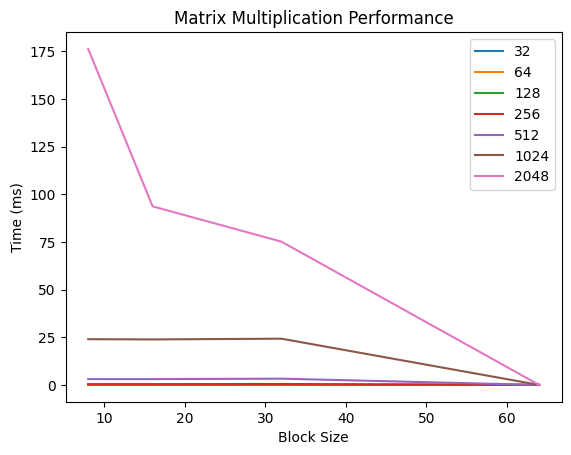

In [13]:
# Read the CSV file into a DataFrame
df = pd.read_csv('ResultsManual.csv')

# Extract data
matrix_sizes = df['MatrixSize'].unique()

# Create a line plot for each matrix size
for size in matrix_sizes:
    subset = df[df['MatrixSize'] == size]
    plt.plot(subset['BlockSize'], subset['Time'], label=f'{size}')

# Set labels and title
plt.xlabel('Block Size')
plt.ylabel('Time (ms)')
plt.title('Matrix Multiplication Performance')

# Show legend
plt.legend()

# Show the plot
plt.show()


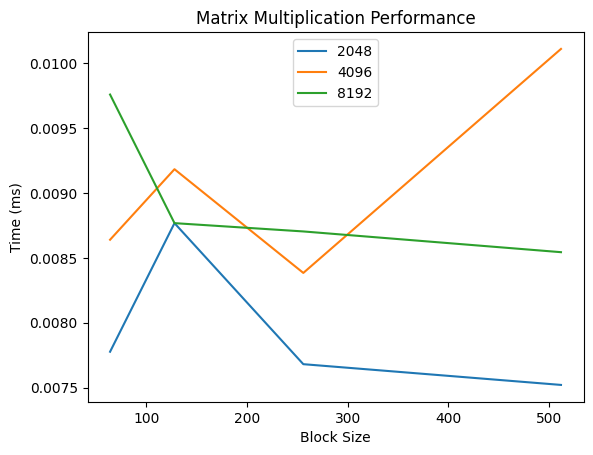

In [14]:
# Read the CSV file into a DataFrame
df = pd.read_csv('ResultsManualLarge.csv')

# Extract data
matrix_sizes = df['MatrixSize'].unique()

# Create a line plot for each matrix size
for size in matrix_sizes:
    subset = df[df['MatrixSize'] == size]
    plt.plot(subset['BlockSize'], subset['Time'], label=f'{size}')

# Set labels and title
plt.xlabel('Block Size')
plt.ylabel('Time (ms)')
plt.title('Matrix Multiplication Performance')

# Show legend
plt.legend()

# Show the plot
plt.show()


###Tiled Optimization

####Basic Tiled Implementation

In [15]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>
#include <cuda_runtime_api.h>

#define tile_width 32

__global__ void tiled_matrix_mult(double *a,double *b, double *c, int n)
{
    __shared__ double ds_M[tile_width][tile_width];
    __shared__ double ds_N[tile_width][tile_width];

  int bx = blockIdx.x;  int by = blockIdx.y;
  int tx = threadIdx.x; int ty = threadIdx.y;

  int Row = by * blockDim.y + ty;
  int Col = bx * blockDim.x + tx;
  double Pvalue = 0;

  // Loop over the M and N tiles required to compute the P element
  for (int p = 0; p < (n-1) / tile_width + 1; ++p) {
    // Collaborative loading of M and N tiles into shared memory
    if(Row < n && p * tile_width+tx < n) {
        ds_M[ty][tx] = a[Row*n + p*tile_width+tx];
    }
    else
    {
        ds_M[ty][tx] = 0.0;
    }
    if (p*tile_width+ty < n && Col < n) {
        ds_N[ty][tx] = b[(p*tile_width+ty)*n + Col];
    }
    else
    {
        ds_N[ty][tx] = 0.0;
    }
    __syncthreads();

    if(Row < n && Col < n) {
        for (int i = 0; i < tile_width; ++i)
           Pvalue += ds_M[ty][i] * ds_N[i][tx];
    }
    __syncthreads();
  }
  if (Row < n && Col < n)
    c[Row*n+Col] = Pvalue;
}



int main(){

    int block_size = 256, matrix_size = 16384;

    //Create and allocate memory for the matrices
    double *a, *b, *c;
    cudaMallocManaged((void **)&a, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&b, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&c, sizeof(double) * matrix_size * matrix_size);

    // initialize matrix A
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        a[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix B
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        b[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix C
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        c[i * matrix_size + j] = 0;
      }
    }

    float gpu_elapsed_time_ms;

    // create cuda events for timing purposes
    cudaEvent_t gpu_start, gpu_stop;
    cudaEventCreate(&gpu_start);
    cudaEventCreate(&gpu_stop);

    //Define block size
    unsigned int grid_rows = (matrix_size + block_size - 1) / block_size;
    unsigned int grid_cols = (matrix_size + block_size - 1) / block_size;
    dim3 dimGrid(grid_cols, grid_rows);
    dim3 dimBlock(block_size, block_size);

    //Launch GPU Kernel
    cudaEventRecord(gpu_start, 0);
    tiled_matrix_mult<<<dimGrid, dimBlock>>>(a, b, c, matrix_size);
    cudaEventRecord(gpu_stop, 0);
    cudaEventSynchronize(gpu_stop);

    //Calculate elapsed time
    cudaEventElapsedTime(&gpu_elapsed_time_ms, gpu_start, gpu_stop);
    printf("Time elapsed on matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, gpu_elapsed_time_ms);

    // free memory
    cudaFree(a);
    cudaFree(b);
    cudaFree(c);

    return 0;
}



Time elapsed on matrix multiplication of 16384x16384 . 16384x16384 on GPU: 51.527424 ms.




###Method Comparison

In [19]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>
#include <cuda_runtime_api.h>

#define tile_width 32

__global__ void tiled_matrix_mult(double *a,double *b, double *c, int n)
{
    __shared__ double ds_M[tile_width][tile_width];
    __shared__ double ds_N[tile_width][tile_width];

  int bx = blockIdx.x;  int by = blockIdx.y;
  int tx = threadIdx.x; int ty = threadIdx.y;

  int Row = by * blockDim.y + ty;
  int Col = bx * blockDim.x + tx;
  double Pvalue = 0;

  // Loop over the M and N tiles required to compute the P element
  for (int p = 0; p < (n-1) / tile_width + 1; ++p) {
    // Collaborative loading of M and N tiles into shared memory
    if(Row < n && p * tile_width+tx < n) {
        ds_M[ty][tx] = a[Row*n + p*tile_width+tx];
    }
    else
    {
        ds_M[ty][tx] = 0.0;
    }
    if (p*tile_width+ty < n && Col < n) {
        ds_N[ty][tx] = b[(p*tile_width+ty)*n + Col];
    }
    else
    {
        ds_N[ty][tx] = 0.0;
    }
    __syncthreads();

    if(Row < n && Col < n) {
        for (int i = 0; i < tile_width; ++i)
           Pvalue += ds_M[ty][i] * ds_N[i][tx];
    }
    __syncthreads();
  }
  if (Row < n && Col < n)
    c[Row*n+Col] = Pvalue;
}

__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    int sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}


int main(){

    int block_size = 256, matrix_size = 8192;

    //Create and allocate memory for the matrices
    double *a, *b, *cn, *ct;
    cudaMallocManaged((void **)&a, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&b, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&cn, sizeof(double) * matrix_size * matrix_size);
    cudaMallocManaged((void **)&ct, sizeof(double) * matrix_size * matrix_size);

    // initialize matrix A
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        a[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix B
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        b[i * matrix_size + j] = (double(rand() % 50))/10.0;
      }
    }

    // initialize matrix C
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        cn[i * matrix_size + j] = 0;
      }
    }

    // initialize matrix C
    for (int i = 0; i < matrix_size; ++i){
      for (int j = 0; j < matrix_size; ++j){
        ct[i * matrix_size + j] = 0;
      }
    }

    float tiled_time;
    float naive_time;

    // create cuda events for timing purposes
    cudaEvent_t gpu_startNaive, gpu_stopNaive;
    cudaEventCreate(&gpu_startNaive);
    cudaEventCreate(&gpu_stopNaive);
    cudaEvent_t gpu_startTiled, gpu_stopTiled;
    cudaEventCreate(&gpu_startTiled);
    cudaEventCreate(&gpu_stopTiled);

    //Define block size
    unsigned int grid_rows = (matrix_size + block_size - 1) / block_size;
    unsigned int grid_cols = (matrix_size + block_size - 1) / block_size;
    dim3 dimGrid(grid_cols, grid_rows);
    dim3 dimBlock(block_size, block_size);

    //Launch GPU Kernel
    cudaEventRecord(gpu_startNaive, 0);
    gpu_matrix_mult<<<dimGrid, dimBlock>>>(a, b, cn, matrix_size);
    cudaEventRecord(gpu_stopNaive, 0);
    cudaEventSynchronize(gpu_stopNaive);

    //Calculate elapsed time
    cudaEventElapsedTime(&naive_time, gpu_startNaive, gpu_stopNaive);
    printf("Time elapsed on Naive matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, naive_time);

    //Launch GPU Kernel
    cudaEventRecord(gpu_startTiled, 0);
    tiled_matrix_mult<<<dimGrid, dimBlock>>>(a, b, ct, matrix_size);
    cudaEventRecord(gpu_stopTiled, 0);
    cudaEventSynchronize(gpu_stopTiled);

    //Calculate elapsed time
    cudaEventElapsedTime(&tiled_time, gpu_startTiled, gpu_stopTiled);
    printf("Time elapsed on Tiled matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, tiled_time);

    // free memory
    cudaFree(a);
    cudaFree(b);
    cudaFree(cn);
    cudaFree(ct);

    return 0;
}



Time elapsed on Naive matrix multiplication of 8192x8192 on GPU: 56.219616 ms.

Time elapsed on Tiled matrix multiplication of 8192x8192 on GPU: 0.014848 ms.




In [21]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>
#include <cuda_runtime_api.h>
#include <random>
#include <fstream>
#include <iostream>

#define tile_width 32

__global__ void tiled_matrix_mult(double *a,double *b, double *c, int n)
{
    __shared__ double ds_M[tile_width][tile_width];
    __shared__ double ds_N[tile_width][tile_width];

  int bx = blockIdx.x;  int by = blockIdx.y;
  int tx = threadIdx.x; int ty = threadIdx.y;

  int Row = by * blockDim.y + ty;
  int Col = bx * blockDim.x + tx;
  double Pvalue = 0;

  // Loop over the M and N tiles required to compute the P element
  for (int p = 0; p < (n-1) / tile_width + 1; ++p) {
    // Collaborative loading of M and N tiles into shared memory
    if(Row < n && p * tile_width+tx < n) {
        ds_M[ty][tx] = a[Row*n + p*tile_width+tx];
    }
    else
    {
        ds_M[ty][tx] = 0.0;
    }
    if (p*tile_width+ty < n && Col < n) {
        ds_N[ty][tx] = b[(p*tile_width+ty)*n + Col];
    }
    else
    {
        ds_N[ty][tx] = 0.0;
    }
    __syncthreads();

    if(Row < n && Col < n) {
        for (int i = 0; i < tile_width; ++i)
           Pvalue += ds_M[ty][i] * ds_N[i][tx];
    }
    __syncthreads();
  }
  if (Row < n && Col < n)
    c[Row*n+Col] = Pvalue;
}

__global__ void gpu_matrix_mult(double *a, double *b, double *c, int n)
{
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (col < n && row < n)
  {
    int sum = 0;
    for (int i = 0; i < n; i++)
    {
      sum += a[row * n + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }

}

int main(){

    int block_size = 256, matrix_size;

    //Open File
    std::ofstream file("ResultsTiled.csv");
    file << "MatrixSize,Technique,Time" << "\n";

    for(matrix_size = 1024; matrix_size <= 16384; matrix_size *= 2){

        //Create and allocate memory for the matrices
        double *a, *b, *cn, *ct;
        cudaMallocManaged((void **)&a, sizeof(double) * matrix_size * matrix_size);
        cudaMallocManaged((void **)&b, sizeof(double) * matrix_size * matrix_size);
        cudaMallocManaged((void **)&cn, sizeof(double) * matrix_size * matrix_size);
        cudaMallocManaged((void **)&ct, sizeof(double) * matrix_size * matrix_size);

        // initialize matrix A
        for (int i = 0; i < matrix_size; ++i){
            for (int j = 0; j < matrix_size; ++j){
                a[i * matrix_size + j] = (double(rand() % 50))/10.0;
            }
        }

        // initialize matrix B
        for (int i = 0; i < matrix_size; ++i){
            for (int j = 0; j < matrix_size; ++j){
                b[i * matrix_size + j] = (double(rand() % 50))/10.0;
            }
        }

        // initialize matrix C
        for (int i = 0; i < matrix_size; ++i){
            for (int j = 0; j < matrix_size; ++j){
                cn[i * matrix_size + j] = 0;
            }
        }

        // initialize matrix C
        for (int i = 0; i < matrix_size; ++i){
            for (int j = 0; j < matrix_size; ++j){
                ct[i * matrix_size + j] = 0;
            }
        }

        float tiled_time;
        float naive_time;

        // create cuda events for timing purposes
        cudaEvent_t gpu_startNaive, gpu_stopNaive;
        cudaEventCreate(&gpu_startNaive);
        cudaEventCreate(&gpu_stopNaive);
        cudaEvent_t gpu_startTiled, gpu_stopTiled;
        cudaEventCreate(&gpu_startTiled);
        cudaEventCreate(&gpu_stopTiled);

        //Define block size
        unsigned int grid_rows = (matrix_size + block_size - 1) / block_size;
        unsigned int grid_cols = (matrix_size + block_size - 1) / block_size;
        dim3 dimGrid(grid_cols, grid_rows);
        dim3 dimBlock(block_size, block_size);

        //Launch GPU Kernel
        cudaEventRecord(gpu_startNaive, 0);
        gpu_matrix_mult<<<dimGrid, dimBlock>>>(a, b, cn, matrix_size);
        cudaEventRecord(gpu_stopNaive, 0);
        cudaEventSynchronize(gpu_stopNaive);

        //Calculate elapsed time
        cudaEventElapsedTime(&naive_time, gpu_startNaive, gpu_stopNaive);
        printf("\nTime elapsed on Naive matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, naive_time);
        if (matrix_size > 1024)
          file<< matrix_size << ", " << "Naive" << ", " << naive_time << "\n";

        //Launch GPU Kernel
        cudaEventRecord(gpu_startTiled, 0);
        tiled_matrix_mult<<<dimGrid, dimBlock>>>(a, b, ct, matrix_size);
        cudaEventRecord(gpu_stopTiled, 0);
        cudaEventSynchronize(gpu_stopTiled);

        //Calculate elapsed time
        cudaEventElapsedTime(&tiled_time, gpu_startTiled, gpu_stopTiled);
        printf("Time elapsed on Tiled matrix multiplication of %dx%d on GPU: %f ms.\n\n",matrix_size, matrix_size, tiled_time);
        if (matrix_size > 1024)
          file<< matrix_size << ", " << "Tiled" << ", " << tiled_time << "\n";

        // free memory
        cudaFree(a);
        cudaFree(b);
        cudaFree(cn);
        cudaFree(ct);
        printf("________________________________________________________\n");
    }


    return 0;
}




Time elapsed on Naive matrix multiplication of 1024x1024 on GPU: 0.292416 ms.

Time elapsed on Tiled matrix multiplication of 1024x1024 on GPU: 0.014240 ms.

________________________________________________________

Time elapsed on Naive matrix multiplication of 2048x2048 on GPU: 0.004640 ms.

Time elapsed on Tiled matrix multiplication of 2048x2048 on GPU: 0.002048 ms.

________________________________________________________

Time elapsed on Naive matrix multiplication of 4096x4096 on GPU: 0.006432 ms.

Time elapsed on Tiled matrix multiplication of 4096x4096 on GPU: 0.002048 ms.

________________________________________________________

Time elapsed on Naive matrix multiplication of 8192x8192 on GPU: 0.006112 ms.

Time elapsed on Tiled matrix multiplication of 8192x8192 on GPU: 0.002080 ms.

________________________________________________________

Time elapsed on Naive matrix multiplication of 16384x16384 on GPU: 0.005792 ms.

Time elapsed on Tiled matrix multiplication of 16384x1

####Plot Results

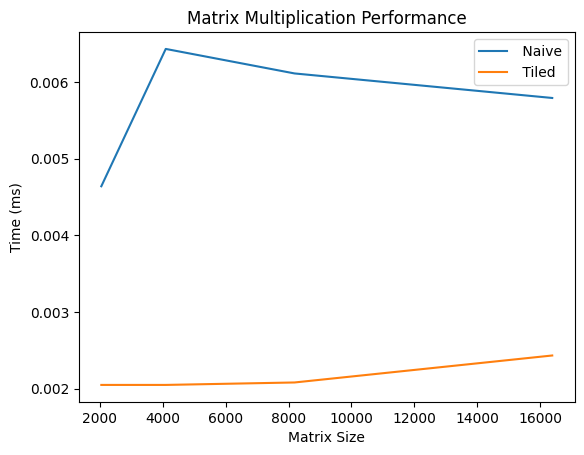

In [22]:
# Read the CSV file into a DataFrame
df = pd.read_csv('ResultsTiled.csv')

# Extract data
matrix_sizes = df['Technique'].unique()

# Create a line plot for each matrix size
for size in matrix_sizes:
    subset = df[df['Technique'] == size]
    plt.plot(subset['MatrixSize'], subset['Time'], label=f'{size}')

# Set labels and title
plt.xlabel('Matrix Size')
plt.ylabel('Time (ms)')
plt.title('Matrix Multiplication Performance')

# Show legend
plt.legend()

# Show the plot
plt.show()
